In [23]:
import SimFunctions
import SimClasses
import SimRNG
from datetime import datetime
from sklearn.linear_model import LinearRegression
import googlemaps
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.physics import Physics
from pyvis.network import Network
from IPython.display import IFrame
from IPython.display import HTML
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest
import pickle
from scipy.stats.distributions import norm, expon, erlang, lognorm, weibull_min, gamma
import statsmodels.api as sm
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)


In [6]:
BSD = pd.read_csv("BikeShare Data\Bike share ridership 2022-08.csv")
readme = pd.read_excel(r"BikeShare Data\bikeshare-ridership-readme.xlsx")


In [7]:
# move Trip_Duration column to position 1
BSD["Trip_Duration"] = BSD.pop("Trip  Duration") * (1/60)  # Convert to Minutes
BSD.insert(1, "Trip_Duration", BSD.pop("Trip_Duration"))


In [46]:
np.random.seed(7)
# create a new DataFrame with just the start and end station names
stations = pd.DataFrame(BSD[['Start Station Name', 'End Station Name']])
stations = stations.sample(int(0.10*(len(BSD))))
# create a new DataFrame with the counts of trips between each pair of stations
counts = stations.groupby(['Start Station Name', 'End Station Name']).size().reset_index(name="NumOfTrips").sort_values(by='NumOfTrips', ascending=False)
# select the top 50 rows
sample_size = counts.sample(7000)#int(0.05*(len(BSD))))
# create a DataFrame with top 50 routes
subset_routes = pd.DataFrame(sample_size[['Start Station Name', 'End Station Name', 'NumOfTrips']])
subset_routes["End Station Name"].value_counts().head()

subset_df = pd.DataFrame.merge(BSD, subset_routes)
subset_df = subset_df.drop("NumOfTrips", axis=1)
subset_df


,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515462,27.033333,7163,08/01/2022 00:01,Yonge St / Wood St,7163.0,08/01/2022 00:28,Yonge St / Wood St,3690,Casual Member
1,17537278,1.400000,7163,08/01/2022 20:28,Yonge St / Wood St,7163.0,08/01/2022 20:29,Yonge St / Wood St,2980,Casual Member
2,17537388,2.083333,7163,08/01/2022 20:34,Yonge St / Wood St,7163.0,08/01/2022 20:36,Yonge St / Wood St,3064,Casual Member
3,17545105,262.100000,7163,08/02/2022 10:22,Yonge St / Wood St,7163.0,08/02/2022 14:44,Yonge St / Wood St,3878,Casual Member
4,17548772,10.833333,7163,08/02/2022 14:06,Yonge St / Wood St,7163.0,08/02/2022 14:17,Yonge St / Wood St,5945,Casual Member
...,...,...,...,...,...,...,...,...,...,...
77274,18314480,14.633333,7324,08/31/2022 21:13,King St W / Charlotte St (West Side),7028.0,08/31/2022 21:28,Gould St / Mutual St,4977,Casual Member
77275,18315195,0.000000,7030,08/31/2022 21:50,Bay St / Wellesley St W,7135.0,08/31/2022 21:50,Hanna Ave / Liberty St,5161,Annual Member
77276,18316291,17.150000,7473,08/31/2022 22:41,Adelaide St W / Strachan Ave,7657.0,08/31/2022 22:59,1 Market St - SMART,278,Casual Member
77277,18317390,22.400000,7473,08/31/2022 23:52,Adelaide St W / Strachan Ave,7657.0,09/01/2022 00:14,1 Market St - SMART,2511,Casual Member


In [47]:
for i, row in subset_df.iterrows():
    trip_length = row["Trip_Duration"]
    # creates a new DataFrame that includes only the rows where the trip duration is at least 2 minutes, but no more than 24 hours, and is not missing (NaN).
    if trip_length < 1 or trip_length * (1/60) > 0.75 or math.isnan(trip_length):
        subset_df = subset_df.drop(index=i)

In [48]:
subset_df

,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515462,27.033333,7163,08/01/2022 00:01,Yonge St / Wood St,7163.0,08/01/2022 00:28,Yonge St / Wood St,3690,Casual Member
1,17537278,1.400000,7163,08/01/2022 20:28,Yonge St / Wood St,7163.0,08/01/2022 20:29,Yonge St / Wood St,2980,Casual Member
2,17537388,2.083333,7163,08/01/2022 20:34,Yonge St / Wood St,7163.0,08/01/2022 20:36,Yonge St / Wood St,3064,Casual Member
4,17548772,10.833333,7163,08/02/2022 14:06,Yonge St / Wood St,7163.0,08/02/2022 14:17,Yonge St / Wood St,5945,Casual Member
5,17568029,1.650000,7163,08/03/2022 08:00,Yonge St / Wood St,7163.0,08/03/2022 08:02,Yonge St / Wood St,3165,Annual Member
...,...,...,...,...,...,...,...,...,...,...
77273,18313940,14.833333,7285,08/31/2022 20:48,Spadina Ave / Harbord St - SMART,7329.0,08/31/2022 21:03,Crawford St / Queen St W,976,Casual Member
77274,18314480,14.633333,7324,08/31/2022 21:13,King St W / Charlotte St (West Side),7028.0,08/31/2022 21:28,Gould St / Mutual St,4977,Casual Member
77276,18316291,17.150000,7473,08/31/2022 22:41,Adelaide St W / Strachan Ave,7657.0,08/31/2022 22:59,1 Market St - SMART,278,Casual Member
77277,18317390,22.400000,7473,08/31/2022 23:52,Adelaide St W / Strachan Ave,7657.0,09/01/2022 00:14,1 Market St - SMART,2511,Casual Member


In [50]:
class TripGenerator(object):
    # code

    def __init__(self, statMap, minbymin, durations, mult=1):
        self.statMap = statMap
        self.tid = 0
        self.minbymin = minbymin
        self.mult = mult
        self.durations = durations

    # runDay_alt2 method for generating trips

    def getAllTripsCombined(self, timeStart):
        # Initialize dictionary with keys = minutes in interval. Entry = list of trips for that minute
        trips = {}
        for i in range(30):
            trips[timeStart+i] = []

        for sid in self.statMap.keys():
            # First, check corner cases
            if not self.minbymin[timeStart].has_key(sid):
                continue
            if self.minbymin[timeStart][sid]["total"] == 0:
                continue
            if not self.statMap.has_key(sid):
                continue

            # Get trip counts for full 30 minute interval
            n = np.random.poisson(
                self.minbymin[timeStart][sid]["total"], size=30)
            totalTrips = sum(n)

            # Get list of all destinations
            total = self.minbymin[timeStart][sid]["total"]
            dests = self.minbymin[timeStart][sid]["dests"].keys()
            distr = map(lambda x: x/float(total),
                        self.minbymin[timeStart][sid]["dests"].values())
            ''' NJ: tolist() converts np array to list, so can use .index later'''
            res = np.random.multinomial(1, distr, size=totalTrips).tolist()

            ''' NJ: the creation of allDests and its two for loops can be avoided. See below '''
            # allDests = []
            # for r in range(totalTrips):
            #     for i in range(len(res[r])):
            #         if res[r][i] == 1: allDests.append(dests[i])

            # Assign trips to the dictionary entry for their respective minute
            count = 0
            for i in range(30):
                # Get trips for ith minute (time = timeStart + i)
                time = timeStart + i
                # j in number of trips at time
                for j in range(n[i]):
                    ''' NJ: .index(1) returns the index corresponding to the value 1. It is faster than a
                    for loop and can be used since there is only one 1'''
                    dest = dests[res[count].index(1)]
                    duration = self.getDuration(sid, dest, time)
                    newTrip = Trip(startTime=time, startLoc=sid,
                                   endTime=time + duration, endLoc=dest,
                                   duration=duration, clock=time, statMap=self.statMap,
                                   tgen=self)
                    # Add new trips to full trip dictionary under minute "time"
                    trips[time].append(newTrip)
                    count += 1

            # DEBUGGING
            if count != totalTrips:
                print("Error creating trip list")
        return trips

    def getAllTripsCombinedAlias(self, timeStart):
        # Initialize dictionary with keys = minutes in interval. Entry = list of trips for that minute
        trips = {}
        for i in range(30):
            trips[timeStart+i] = []

        for sid in self.statMap.keys():
            # First, check corner cases
            if not self.minbymin[timeStart].has_key(sid):
                continue
            if self.minbymin[timeStart][sid]["total"] == 0:
                continue
            if not self.statMap.has_key(sid):
                continue

            # Get trip counts for full 30 minute interval
            n = np.random.poisson(
                self.minbymin[timeStart][sid]["total"], size=30)
            totalTrips = sum(n)

            # Get list of all destinations
            total = self.minbymin[timeStart][sid]["total"]
            dests = self.minbymin[timeStart][sid]["dests"].keys()
            distr = map(lambda x: x/float(total),
                        self.minbymin[timeStart][sid]["dests"].values())
            # do the setup for alias once every 30 minutes
            J, q = alias_setup(distr)
            # draw all the destinations
            destIndex = alias_draw_n(J, q, totalTrips)
            ts = timeStart + np.random.randint(30, size=totalTrips)

            # Assign trips to the dictionary entry for their respective minute
            for i in range(totalTrips):
                time = int(ts[i])
                dest = dests[destIndex[i]]
                duration = self.getDuration(sid, dest, time)
                newTrip = Trip(startTime=time, startLoc=sid,
                               endTime=time + duration, endLoc=dest,
                               duration=duration, clock=time, statMap=self.statMap,
                               tgen=self)
                trips[time].append(newTrip)
        return trips

    def getAllTripsCombinedCond(self, timeStart):
        # Initialize dictionary with keys = minutes in interval. Entry = list of trips for that minute
        trips = {}
        for i in range(30):
            trips[timeStart+i] = []

        for sid in self.statMap.keys():
            # First, check corner cases
            if not self.minbymin[timeStart].has_key(sid):
                continue
            if self.minbymin[timeStart][sid]["total"] == 0:
                continue
            if not self.statMap.has_key(sid):
                continue

            # Get trip counts for full 30 minute interval
            totalTrips = np.random.poisson(
                self.minbymin[timeStart][sid]["total"]*30, size=1)

            # Get list of all destinations
            total = self.minbymin[timeStart][sid]["total"]
            dests = self.minbymin[timeStart][sid]["dests"].keys()
            distr = map(lambda x: x/float(total),
                        self.minbymin[timeStart][sid]["dests"].values())
            res = np.random.multinomial(1, distr, size=totalTrips).tolist()

            ts = timeStart + np.random.randint(30, size=totalTrips)
            # Assign trips to the dictionary entry for their respective minute
            for i in range(totalTrips):
                ''' Poisson Process property: conditioning on number of arrivals in [0,T],
                the time of arrivals is uniform in [0,T]. Here we use the discrete uniform.'''
                time = int(ts[i])
                dest = dests[res[i].index(1)]
                duration = self.getDuration(sid, dest, time)
                newTrip = Trip(startTime=time, startLoc=sid,
                               endTime=time + duration, endLoc=dest,
                               duration=duration, clock=time, statMap=self.statMap,
                               tgen=self)
                trips[time].append(newTrip)
        return trips

    ''' runDay_original methods for generating trips '''

    def generateTrips(self, timeValue):
        trips = []
        for s1 in self.statMap.keys():
            trips.extend(self.getTrips(s1, timeValue))
        return trips

    def getTrips(self, sid, time):
        if not self.minbymin[time-time % 30].has_key(sid):
            return []
        if self.minbymin[time-time % 30][sid]["total"] == 0:
            return []
        if not self.statMap.has_key(sid):
            return []

        numberTrips = np.random.poisson(self.minbymin[time-time % 30][sid]["total"] *
                                           self.mult)

        trips = []
        for t in range(numberTrips):
            dest = self.getWhereTripGoing(sid, time)
            duration = self.getDuration(sid, dest, time)
            newTrip = Trip(time, sid, time+duration, dest,
                           duration, time, statMap=self.statMap,
                           tgen=self)
            trips.append(newTrip)
        return trips

    def getWhereTripGoing(self, s1, time):
        total = self.minbymin[time-time % 30][s1]["total"]
        dests = self.minbymin[time-time % 30][s1]["dests"].keys()
        distr = map(lambda x: x/float(total),
                    self.minbymin[time-time % 30][s1]["dests"].values())
        res = np.random.multinomial(1, distr)
        for i in range(len(res)):
            if res[i] == 1:
                return dests[i]

    def getDuration(self, s1, s2, t, ind=None):
        # if not self.minbymin.has_key(t-t%30):
        #     # print "Warning: Time %d has no key" %t
        #     return 10
        # if not self.minbymin[t-t%30].has_key(s1):
        #     # print "Warning: sid=%d has no key at time %d" %(s1,t)
        #     return 10
        # if not self.minbymin[t-t%30][s1]["durations"].has_key(s2):
        #     # print "Warning: s1=%d has no duration key to s2=%d at time %d" %(s1,s2,t)
        #     return 10

        sigma = 0.2571  # sqrt of 0.0661117309208
        mult = self.durations[s1][s2]

        ''' If ind=None, this is called when generating the trip list, so return one duration. If ind = 1 or 2,
        meaning ind number of failedEnds has been triggered, return duration without affecting the
        random number cycle'''
        if ind is None:
            duration = int(round(mult*np.random.lognormal(0, sigma)))
        else:
            state = np.random.get_state()
            # np.random.RandomState() # Start a new stream
            duration = int(round(mult*np.random.lognormal(0, sigma)))
            np.random.set_state(state)  # Restore state
        return duration


# MGS (A2)

In [ ]:

"""
MG1 Code
"""

def MGS(s):
    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    Server.SetUnits(s)  # changed SetUnits(1) to SetUnits(s)
    MeanTBA = 1.0
    MeanST = 0.8*s      # multiplyed service time by s
    Phases = 3
    RunLength = 55000.0
    WarmUp = 5000.0

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []

    def Arrival():
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Customer = SimClasses.Entity()
        Queue.Add(Customer)
                
        if (Server.Busy < s) and (Server.Busy >= 0):   # modified arrival function as the simulation can have more than 1 server 
                                    # meaning Server.Busy can take on more values than 0 or 1
                                    # the model will seize 1 server if there is available spots in server
                Server.Seize(1)
                SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))            
        else:
            pass
   
    def EndOfService():
        DepartingCustomer = Queue.Remove()
        if DepartingCustomer is not None:
            Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)  
                                                        # modified EndOfService function to account for more than one server
                                                        # We only record a time if there is a DepartingCustomer
        else:
            pass
        
        if Queue.NumQueue() >= s:
            SimFunctions.Schedule(Calendar, "EndOfService",SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Server.Free(1)

    for reps in range(0, 10, 1):

        SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar, "EndSimulation", RunLength)
        #SimFunctions.Schedule(Calendar, "ClearIt", WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())
   
   
    print("For s =", s)
    print("Estimated Expected Average wait:", np.mean(AllWaitMean))
    print("Estimated Expected Average queue-length:", np.mean(AllQueueMean))
    print("Estimated Expected Average utilization:", np.mean(AllServerMean))
    print("Estimated Expected Queue Number utilization:", np.mean(AllQueueNum))
    
    # convert the output to a dataframe and write to a .csv file
    q4_output = {"AllWaitMean": AllWaitMean, "AllQueueMean": AllQueueMean,
            "AllQueueNum": AllQueueNum, "AllServerMean": AllServerMean}
    return pd.DataFrame(q4_output)


In [ ]:
s1_q4_output = MGS(1)
s1_q4_output.describe()[1:2]


# MG1c (A2)

In [ ]:

def Dock_Sim(Dock_Size, NumOfBikes, MeanTR, MeanTBA, MeanST):

    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Dock_Station = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Dock_Station)

    Dock_Station.SetUnits(NumOfBikes)

    Phases = 3
    RunLength = 550
    WarmUp = 50

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []

    print("Dock_Size = {}, MeanTR = {}, MeanTBA = {}, MeanST = {}, ServiceRate = {}".format(
        Dock_Size, MeanTR, MeanTBA, MeanST, 1/MeanST))

    def Arrival():
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Bike = SimClasses.Entity()

        # number of customers in queue and servered
        Num_Bikes = Queue.NumQueue() + 1
        #print("DOG ",Num_Bikes)
        if Dock_Size < Num_Bikes:  # if Dock_Size < number of customer ahead of them then the customer we retry with exponential time
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))

        Queue.Add(Bike)

        if (Dock_Station.Busy < NumOfBikes) and (Dock_Station.Busy >= 0):
            Dock_Station.Seize(1)
            SimFunctions.Schedule(Calendar, "EndOfService",
                                  SimRNG.Erlang(Phases, MeanST, 2))

    def Retrial():  # retrail function
        Bike = SimClasses.Entity()
        # number of people in the system ahead of customer
        Num_Bikes = Queue.NumQueue() + 1
        #print("CAT ",num_customer_queue)
        if Dock_Size < Num_Bikes:  # account of the same process where if there is still more customers ahead than the will arrival again
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))
        else:
            Queue.Add(Bike)
            if (Dock_Station.Busy < NumOfBikes) and (Dock_Station.Busy >= 0):
                Dock_Station.Seize(1)
                SimFunctions.Schedule(
                    Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))

    def EndOfService():
        DepartingCustomer = Queue.Remove()
        Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)

        if Queue.NumQueue() > 0:
            SimFunctions.Schedule(Calendar, "EndOfService",
                                  SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Dock_Station.Free(1)

    for reps in range(0, 10, 1):

        SimFunctions.SimFunctionsInit(
            Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar, "EndSimulation", RunLength)
        SimFunctions.Schedule(Calendar, "ClearIt", WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "Retrial":  # added Retrial event type
                Retrial()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Dock_Station.Mean())

    q5_output = {"Estimated Expected Average wait:": AllWaitMean, "Estimated Expected Average queue-length:": AllQueueMean,
                 "Estimated Expected Queue Number:": AllQueueNum, "Estimated Expected Average utilization:": AllServerMean}
    return pd.DataFrame(q5_output)


# MGS Hostpital Servers

In [51]:

def Dock_Sim(bike):
    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Server = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Server)

    Server.SetUnits(bike)  # changed SetUnits(1) to SetUnits(bike)
    MeanTBA = 30
    MeanST = 15      # multiplyed service time by bike
    Phases = 4
    staff = 170

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []

    def CI_95(data):    # define 95% confidence interval function
        a = np.array(data)
        n = len(a)
        m = np.mean(a)
        sd = np.std(a, ddof=1)
        hw = 1.96*sd / np.sqrt(n)
        return m, m-hw, m+hw

    def Arrival():
        #SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Customer = SimClasses.Entity()
        Queue.Add(Customer)

        if Server.Busy < bike:
            if Server.Busy >= 0:   # modified arrival function as the simulation can have more than 1 server
                # meaning Server.Busy can take on more values than 0 or 1
                # the model will seize 1 server if there is available spots in server
                Server.Seize(1)
                SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))
        else:
            pass

    def EndOfService(count):
        count += 1
        DepartingBike = Queue.Remove()
        if DepartingBike is not None:
            Wait.Record(SimClasses.Clock - DepartingBike.CreateTime)
            # modified EndOfService function to account for more than one server
            # We only record a time if there is a DepartingBike
        else:
            pass
        if Queue.NumQueue() >= bike:
            SimFunctions.Schedule(Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Server.Free(1)
        return count

    for reps in range(0, 100, 1):
        count = 1  # initalize count
        SimFunctions.SimFunctionsInit(
            Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        for _ in range(staff):  # schedule the staff on the calendar for each rep
            SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Uniform(0, MeanTBA, 5))
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            count = EndOfService(count)

        while count < staff:  # if count >= staff then End of Simulation
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "EndOfService":
                count = EndOfService(count)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Server.Mean())

    output = {"AllWaitMean": AllWaitMean, "CI_95 (-)": CI_95(AllWaitMean)[1], "CI_95 (+)": CI_95(AllWaitMean)[2], "AllQueueMean": np.mean(AllQueueMean), "AllServerMean:": np.mean(AllServerMean)}
    return pd.DataFrame(output)


Text(0.5, 1.0, 'Number of Servers per average wait times')

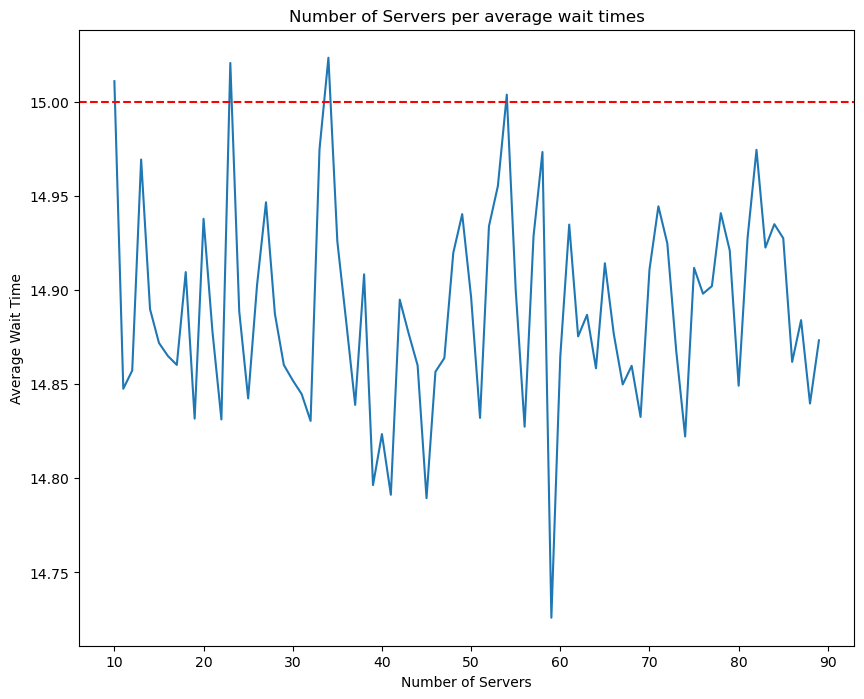

In [53]:
s_list = [i for i in range(10, 90)]
val = []
wait = 0
final_s = 0
for s in s_list:
    pd_out = Bike_Sim(100)
    wait = pd_out.describe().iloc[1][0]
    val.append(wait)
    if wait < 15:
        #print(s)
        final_s = s
        
plt.figure(figsize=(10, 8))
plt.plot(s_list, val)
#plt.xticks([i for i in range(40, 90)])
plt.ylabel("Average Wait Time")
plt.xlabel("Number of Servers")
plt.axhline(y=15, color='r', linestyle='--')
plt.title("Number of Servers per average wait times")


# Bike Simulation

In [26]:
subset_df.head()

,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,17515495,6.666667,7168,08/01/2022 00:04,Queens Quay / Yonge St,7060.0,08/01/2022 00:11,Princess St / Adelaide St E,2168,Annual Member
1,17605359,8.250000,7168,08/04/2022 18:54,Queens Quay / Yonge St,7060.0,08/04/2022 19:02,Princess St / Adelaide St E,3125,Casual Member
2,17626598,13.283333,7168,08/05/2022 17:19,Queens Quay / Yonge St,7060.0,08/05/2022 17:32,Princess St / Adelaide St E,5064,Casual Member
3,17626612,13.000000,7168,08/05/2022 17:19,Queens Quay / Yonge St,7060.0,08/05/2022 17:32,Princess St / Adelaide St E,3742,Casual Member
4,17626630,12.383333,7168,08/05/2022 17:19,Queens Quay / Yonge St,7060.0,08/05/2022 17:32,Princess St / Adelaide St E,720,Casual Member


In [27]:
# randomly sample start station 

start_stations_id = subset_df["Start Station Id"]
end_station_id = subset_df["End Station Id"]




In [55]:
# Use groupby() to get mean average arrivals and departures per time period
arrival_df = subset_df.groupby(['End Station Id','Trip_Duration'], as_index=False)['Start Station Id'].count()
arrival_df = arrival_df.groupby(['End Station Id','Trip_Duration'])['Start Station Id'].mean().round(2).unstack(level=0).fillna(0)
arrival_df


End Station Id,7000.0,7001.0,7002.0,7003.0,7004.0,7005.0,7006.0,7007.0,7008.0,7009.0,...,7665.0,7666.0,7667.0,7668.0,7670.0,7671.0,7675.0,7677.0,7680.0,7681.0
Trip_Duration,,,,,,,,,,,,,,,,,,,,,
1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.033333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.066667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44.933333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
"""
MGSC
"""
def Dock_Sim(Dock_Size, NumOfBikes, MeanTR, MeanTBA, MeanST):

    ZSimRNG = SimRNG.InitializeRNSeed()

    Queue = SimClasses.FIFOQueue()
    Wait = SimClasses.DTStat()
    Dock_Station = SimClasses.Resource()
    Calendar = SimClasses.EventCalendar()

    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    TheDTStats.append(Wait)
    TheQueues.append(Queue)
    TheResources.append(Dock_Station)

    Dock_Station.SetUnits(NumOfBikes)

    Phases = 3
    RunLength = 550
    WarmUp = 50

    AllWaitMean = []
    AllQueueMean = []
    AllQueueNum = []
    AllServerMean = []
    

    print("Dock_Size = {}, MeanTR = {}, MeanTBA = {}, MeanST = {}, ServiceRate = {}".format(
        Dock_Size, MeanTR, MeanTBA, MeanST, 1/MeanST))

    def Arrival():
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        Bike = SimClasses.Entity()

        # number of customers in queue and servered
        Num_Bikes = Queue.NumQueue() + 1
        #print("DOG ",Num_Bikes)
        if Dock_Size < Num_Bikes:  # if Dock_Size < number of customer ahead of them then the customer we retry with exponential time
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))
            

        Queue.Add(Bike)

        if (Dock_Station.Busy < NumOfBikes) and (Dock_Station.Busy >= 0):
            Dock_Station.Seize(1)
            SimFunctions.Schedule(Calendar, "EndOfService",
                                  SimRNG.Erlang(Phases, MeanST, 2))

    def Retrial():  # retrail function
        Bike = SimClasses.Entity()
        # number of people in the system ahead of customer
        Num_Bikes = Queue.NumQueue() + 1
        #print("CAT ",num_customer_queue)
        if Dock_Size < Num_Bikes:  # account of the same process where if there is still more customers ahead than the will arrival again
            SimFunctions.Schedule(Calendar, "Retrial", SimRNG.Expon(MeanTR, 5))
        else:
            Queue.Add(Bike)
            if (Dock_Station.Busy < NumOfBikes) and (Dock_Station.Busy >= 0):
                Dock_Station.Seize(1)
                SimFunctions.Schedule(
                    Calendar, "EndOfService", SimRNG.Erlang(Phases, MeanST, 2))

    def EndOfService():
        DepartingCustomer = Queue.Remove()
        Wait.Record(SimClasses.Clock - DepartingCustomer.CreateTime)

        if Queue.NumQueue() > 0:
            SimFunctions.Schedule(Calendar, "EndOfService",
                                  SimRNG.Erlang(Phases, MeanST, 2))
        else:
            Dock_Station.Free(1)

    for reps in range(0, 10, 1):

        SimFunctions.SimFunctionsInit(
            Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Arrival", SimRNG.Expon(MeanTBA, 1))
        SimFunctions.Schedule(Calendar, "EndSimulation", RunLength)
        SimFunctions.Schedule(Calendar, "ClearIt", WarmUp)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Arrival":
            Arrival()
        elif NextEvent.EventType == "EndOfService":
            EndOfService()
        elif NextEvent.EventType == "ClearIt":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            if NextEvent.EventType == "Arrival":
                Arrival()
            elif NextEvent.EventType == "Retrial":  # added Retrial event type
                Retrial()
            elif NextEvent.EventType == "EndOfService":
                EndOfService()
            elif NextEvent.EventType == "ClearIt":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)

        AllWaitMean.append(Wait.Mean())
        AllQueueMean.append(Queue.Mean())
        AllQueueNum.append(Queue.NumQueue())
        AllServerMean.append(Dock_Station.Mean())

    q5_output = {"Estimated Expected Average wait:": AllWaitMean, "Estimated Expected Average queue-length:": AllQueueMean,
                 "Estimated Expected Queue Number:": AllQueueNum, "Estimated Expected Average utilization:": AllServerMean}
    return pd.DataFrame(q5_output)
